# Information Retrival 

In [5]:
!python -m ipykernal install --user --name mykernal 

/Users/krutheekarajkumar/anaconda3/bin/python: No module named ipykernal


In [7]:
!pip install whoosh

     |████████████████████████████████| 471kB 6.4MB/s eta 0:00:01


In [2]:
from whoosh import index, writing
from whoosh.fields import Schema, TEXT, KEYWORD, ID, STORED
from whoosh.analysis import *
from whoosh.qparser import QueryParser
import os.path
from pathlib import Path
import tempfile
import subprocess

In [6]:
DATA_DIR = "government"
DOCUMENTS_DIR = os.path.join(DATA_DIR, "documents")
TOPIC_FILE = os.path.join(DATA_DIR, "gov.topics")
QRELS_FILE = os.path.join(DATA_DIR, "gov.qrels")
TREC_EVAL = os.path.join("trec_eval", "trec_eval")

The Chosen measure is: <b>MAP - mean average precision</b>

### Reason for choosing Mean Average Precision
Mean Average Precision is the average of the precision value obtained for the set of top 'k' documents existing after each relevant document is retrieved, therefore this measure considers precision and takes into account the rank. 

In [7]:
mySchema = Schema(file_path = ID(stored=True),
                  file_content = TEXT(analyzer = RegexTokenizer()))
def createIndex(schema):
    indexDir = tempfile.mkdtemp()
    return index.create_in(indexDir, schema)

myIndex = createIndex(mySchema)

In [8]:
def addFilesToIndex(indexObj, fileList):
    # open writer
    writer = writing.BufferedWriter(indexObj, period=None, limit=1000)
    try:
        # write each file to index
        # Here 'fileList' is an object that is iterable - 'lab-data/documents/email01'
        for docNum, filePath in enumerate(fileList):
            with open(filePath, "r", encoding="utf-8") as f:
                fileContent = f.read()
                writer.add_document(file_path = filePath,
                                    file_content = fileContent)
                if (docNum+1 % 1000 == 0):
                    print("already indexed:", docNum+1)
        print("done indexing.")

    finally:
        # close the index
        writer.close()

In [9]:
filesToIndex = [str(filePath) for filePath in Path(DOCUMENTS_DIR).glob("**/*") if filePath.is_file()]

In [10]:
filesToIndex[:5]

[]

In [11]:
print("number of files:", len(filesToIndex))

number of files: 0


In [12]:
addFilesToIndex(myIndex, filesToIndex)

done indexing.


In [15]:
mySchema = Schema(file_path = ID(stored=True),
                  file_content = TEXT(analyzer = RegexTokenizer()))
INDEX_Q2 = createIndex(mySchema) # Replace None with index
QP_Q2 = QueryParser("file_content", schema=myIndex.schema) # Replace None with query parser
SEARCHER_Q2 = myIndex.searcher()# Replace None with searcher

In [16]:
with open(TOPIC_FILE, "r") as f:
    print(f.read())

1 mining gold silver coal
2 juvenile delinquency
4 wireless communications
6 physical therapists
7 cotton industry
9 genealogy searches
10 Physical Fitness
14 Agricultural biotechnology
16 Emergency and disaster preparedness assistance
18 Shipwrecks
19 Cybercrime, internet fraud, and cyber fraud
22 Veteran's Benefits
24 Air Bag Safety
26 Nuclear power plants
28 Early Childhood Education



In [17]:
with open(QRELS_FILE, "r") as f:
    qrels10 = f.readlines()[:10]
    print("".join(qrels10))

1 0 G00-00-0681214 0
1 0 G00-00-0945765 0
1 0 G00-00-1006224 1
1 0 G00-00-1591495 0
1 0 G00-00-2764912 0
1 0 G00-00-3253540 0
1 0 G00-00-3717374 0
1 0 G00-01-0270065 0
1 0 G00-01-0400712 0
1 0 G00-01-0682299 0



In [22]:
def trecEval(topicFile, qrelsFile, queryParser, searcher):
    # Load topic file - a list of topics(search phrases) used for evalutation
    with open(topicFile, "r") as tf:
        topics = tf.read().splitlines()
    #print(topics) # -- list
    # create an output file to which we'll write our results
    tempOutputFile = tempfile.mkstemp()[1]
    with open(tempOutputFile, "w") as outputTRECFile:
        # for each evaluated topic:
        # build a query and record the results in the file in TREC_EVAL format
        for topic in topics:
            topic_id, topic_phrase = tuple(topic.split(" ", 1))
            topicQuery = queryParser.parse(topic_phrase)
            topicResults = searcher.search(topicQuery, limit=None)
            for (docnum, result) in enumerate(topicResults):
                score = topicResults.score(docnum)
                outputTRECFile.write("%s Q0 %s %d %lf test\n" % (topic_id, os.path.basename(result["file_path"]), docnum, score))
    
    result = subprocess.run([TREC_EVAL, '-q', qrelsFile, tempOutputFile], stdout=subprocess.PIPE)
    print(result.stdout.decode())

In [25]:
trecEval(TOPIC_FILE, QRELS_FILE, QP_Q2, SEARCHER_Q2)

### MAP with baseline Whoosh system

map(all) = <b>0.1971</b>

### The Topics that did well and the topics that did poorly
The topic where the MAP value was 0 were: 
1, 2, 6, 7, 9, 16, 28 

Topic 19 wasn't included in the list and the reason for this is that there were no documents that were retrived by the system. 

The topic which did have a MAP value as a consequent of having a system retriving a relevant document: 
4=0.0312 , 10=0.167, 14=0.25, 18=1.0, 22=0.2, 24=1.0, 26=0.1111

Gauging from the returned documents, topic 14 had the most promising results. 

### Rason for improvement of Whoosh's performance on this test collection
The first way to improve the test collections would be to introduce text tokenization and filteration. <br>For Example: <br>The queries need not consider any puncuation or unneccesary white space. Uppercase and lowercase letters need not be a deciding factor in query searching. Using different variations of a query term which has the same meaning, however could be listed different in the context due to grammer but carry the same meaning. 

In [26]:
import nltk
from nltk.stem import *

In [32]:
from whoosh.analysis import Filter
class CustomFilter(Filter):
    is_morph = True
    def __init__(self, filterFunc, *args, **kwargs):
        self.customFilter = filterFunc
        self.args = args
        self.kwargs = kwargs
    def __eq__(self):
        return (other
                and self.__class__ is other.__class__)
    def __call__(self, tokens):
        for t in tokens:
            if t.mode == 'query': # if called by query parser
                t.text = self.customFilter(t.text, *self.args, **self.kwargs)
                yield t
            else: # == 'index' if called by indexer
                t.text = self.customFilter(t.text, *self.args, **self.kwargs)
                yield t

In [33]:
tokenizer = RegexTokenizer()| StemFilter()| LowercaseFilter() | IntraWordFilter() | StopFilter() |CustomFilter(WordNetLemmatizer().lemmatize, 'v')|CustomFilter(LancasterStemmer().stem)
#[token.text for token in stmLwrStpIntraAnalyzer()]

In [34]:
Schema_Q3 = Schema(file_path = ID(stored=True),
                  file_content = TEXT(analyzer = tokenizer))
INDEX_Q3 = createIndex(Schema_Q3) # Replace None with your index for Q3
addFilesToIndex(INDEX_Q3, filesToIndex)
QP_Q3 =  QueryParser("file_content", schema=INDEX_Q3.schema) # Replace None with your query parser for Q3
SEARCHER_Q3 = INDEX_Q3.searcher() # Replace None with your searcher for Q3


done indexing.


In [35]:
trecEval(TOPIC_FILE, QRELS_FILE, QP_Q3, SEARCHER_Q3) 

### Modifications and improvements made and the effect on queries in performance
There were eight filters and tolkenziers that were applied to the system. These included StemFilter which was able to get multiple versions of the same root word, and stopfilter which was able to ignore the common words and give importance to the rare words by a list of predefined words. IntraWordFilter were able to concatinate hyphenated word, this filter might not have been necessary as the query words did not contain any such hyphenated term. ordNetLemmatizer().lemmatize, 'v, tokenization features creates past tense versions of verbs and LancasterStemmer().stem is able to remove the suffix so as to return the root word for a search funciton <br> It would apprear as though the number of false positives had increased after the return of the filters were applied, there was a larger amount of data that was being retrieved but was not relevant. False positive numbers however, seemed to be held constant, from the previous system. <br> Overall there was definite improvement from the previous test to the next, the number of queries processed had increased by one, the true positive values had also increased which meant more relevant information was retrieved.The number of False negatives had also increased dramatically. 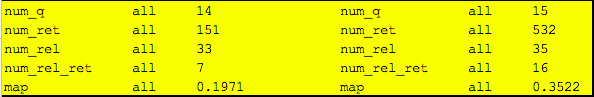. <center>The above picture compares the data from all the results from the first test to the second.

##### Final thoughts on the changed: 
<br> The idea still indicated an overall improvement in the system. The MAP values over all the queries was higher than that without of the filters and tokenizers. Compromize was seen at only a small portion of the results and this was due to the large number of retrieved documents - however the higher MAP values suggest that the average reader would find their answers within the top few searches.  

In [36]:
GRAD_STUDENT = True # Changed to true for graduate student deliverable 

### Ways to improve Whoosh's performance on this test collection:
Any user would be more likely to enjoy their search experience when the information/relevant documents are present in an orderly fashion, such that the most relevant topics would be present at the top of the list of the retrived documents. This can be done by using scoring methods provided by whoosh. The position of the ranks of the relevant documents can be read through the "recip rank" number of the trec_eval return. The reciprocal of this number gives the position of the first relevant document present in the list. For Query 6, this document is present in the 6th position, ideally the search system would present this relevant document in the first position as there is only one relevant document in the whole list of retrived document. Scoring methods would allow for this to happen. The default method the searcher applies is the BM15F method and it would be beneficial to study which is there are other cases there a different sorting system would be more effective

In [199]:
from whoosh import scoring

In [205]:
#Schema_Q4 = Schema(file_path = ID(stored=True),file_content = TEXT(analyzer = tokenizer))
INDEX_Q4 = createIndex(Schema_Q3) 
addFilesToIndex(INDEX_Q4, filesToIndex)
QP_Q4 =  QueryParser("file_content", schema=INDEX_Q4.schema) 

done indexing.


In [31]:
#SEARCHER_Q4 = INDEX_Q4.searcher(weighting=scoring.BM25F()) 
#The following scoring function uses the position of the first occurance of a term in each document to calculate the
#score, so documents with the given term earlier in the document will score higher:
def pos_score_fn(searcher, fieldname, text, matcher):
    poses = matcher.value_as("positions")
    return 1.0 / (poses[0] + 1)
pos_weighting = scoring.FunctionWeighting(pos_score_fn)
mw = scoring.MultiWeighting(scoring.BM25F(), id=scoring.Frequency(), keys=scoring.TF_IDF())
#SEARCHER_Q4 = INDEX_Q4.searcher(weighting=pos_weighting) 
#SEARCHER_Q4 = INDEX_Q4.searcher(weighting=scoring.Frequency()) 
#SEARCHER_Q4 = INDEX_Q4.searcher(weighting=scoring.TF_IDF()) 
SEARCHER_Q4 = INDEX_Q4.searcher(weighting=mw) 

trecEval(TOPIC_FILE, QRELS_FILE, QP_Q4, SEARCHER_Q4) 


NameError: name 'scoring' is not defined

### Modications that caused improvements 
Multiple scoring methods were applied to study the effect in the resulting data that was retrived. Namely <li>BM25F(): which confirmed that it was the default method that was applied to the previous dataset <li> The function pos_score_fn() [taken from the whoosh documentation]: where the higher the position of the relevant document, the higher the allotted score was for that query <li> MultiWeighting() [From whoosh documentation]: Where the primary method was BM25F, and the ID fields had Frequency and the key fields had the TF_ID scoring attached to it. <li>Frequency: Where the more number of times a query word is present in the document the higher the score would be <li> TF_ID: scored the query based on the term in the document and the document in the collection. <br> Most of the methods did not show a large improvement on the MAP number and this was because the default method used BM25F, returned the optimal solution. The maximum MAP value for all the topics was seen for position scoring function. The only topics that an improvement was seen were 6, 9, 10, 28. For example, query 6 originally placed the first relevant document in position 6 and after the scoring method was applied, that position was moved to the 1st position. The scoring function places the relevant documents higher up on the list, there by causing the MAP values to also increase. 
    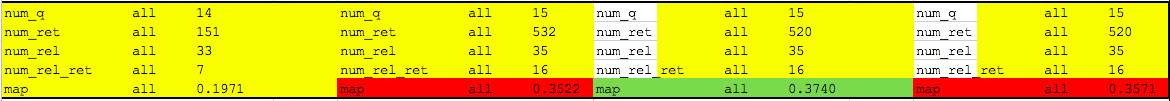<center>The columns above follow: results without any filters or tokenizations, results with default scoring(BM25F), filters and tokenization, results with the scoring function and results with multiple weights (left to right)</center>
    <br>The most improvement was seen for query 28 as the number of retrived documents was reduced from 64 to 52,52 (BM25F, position scoring function, multiweighting respectively), this caused the ranking for the relevant retrivals (true positives) to be placed higher in rank, thereby increasing the MAP value. Almost all queries had a larger MAP value when scored by the default or the multiweight method for induvidual queries, there by indicating that BM25F had the most effective scoring method for this data set. 

### Final thoughts on the improvements
It was a good idea to realize that the default scoring method BM25F was the best scoring method available for most fields. However there are some fields which would be more effectively sorted by using frequency or TF_IDF, it would be benificial to investigate which particular fields would benefit more from such sorting

## Validation

In [217]:
# Run the following cells to make sure your code returns the correct value types

In [218]:
from whoosh.index import FileIndex
from whoosh.qparser import QueryParser
from whoosh.searching import Searcher
import os.path

In [219]:
assert(isinstance(INDEX_Q2, FileIndex)), "Index Type"
assert(isinstance(QP_Q2, QueryParser)), "Query Parser Type"
assert(isinstance(SEARCHER_Q2, Searcher)), "Searcher Type"
print("Q2 Types Validated")

Q2 Types Validated


### Q2 Validation

In [220]:
assert(isinstance(INDEX_Q3, FileIndex)), "Index Type"
assert(isinstance(QP_Q3, QueryParser)), "Query Parser Type"
assert(isinstance(SEARCHER_Q3, Searcher)), "Searcher Type"
print("Q3 Types Validated")

Q3 Types Validated


### Q3 Validation

In [221]:
assert((not GRAD_STUDENT) or isinstance(INDEX_Q4, FileIndex)), "Index Type"
assert((not GRAD_STUDENT) or isinstance(QP_Q4, QueryParser)), "Query Parser Type"
assert((not GRAD_STUDENT) or isinstance(SEARCHER_Q4, Searcher)), "Searcher Type"
print("Q4 Types Validated")

Q4 Types Validated


### Q4 Validation (Graduate Students)

### WORKS REFERENCED:
https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-ranked-retrieval-results-1.html<br>
https://nlp.stanford.edu/IR-book/pdf/08eval.pdf<br>
https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)<br>
https://github.com/usnistgov/trec_eval/tree/master/test<br>
https://media.readthedocs.org/pdf/whoosh/latest/whoosh.pdf<br>
